In [37]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [38]:
# Step 1: Load and Prepare Dataset
df = pd.read_csv("breast-cancer.csv")

In [39]:
# Step 3: Initial Inspection
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [40]:
# Drop unnecessary columns
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True, errors='ignore')

# Encode target: M → 1 (Malignant), B → 0 (Benign)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [41]:
# Select features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [42]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
# Step : Train Linear SVM
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [45]:
y_pred_linear = svm_linear.predict(X_test)

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_linear))
print("Classification Report:\n", classification_report(y_test, y_pred_linear))

Linear SVM Accuracy: 0.9649122807017544
Confusion Matrix:
 [[72  0]
 [ 4 38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [46]:
# Step : Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

In [47]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=0)
grid.fit(X_train, y_train)

print("Best Parameters (RBF):", grid.best_params_)
print("Best Cross-Validation Score: {:.2f}%".format(grid.best_score_ * 100))

Best Parameters (RBF): {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross-Validation Score: 97.58%


In [48]:
# Step : Evaluate Best Model on Test Set
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Accuracy of Tuned RBF SVM on Test Set:", accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Accuracy of Tuned RBF SVM on Test Set: 0.956140350877193
Confusion Matrix:
 [[70  2]
 [ 3 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [49]:
# Step : Cross-Validation Score of Final Model
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_scaled, y, cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy: {:.2f}%".format(np.mean(cv_scores) * 100))

Cross-Validation Accuracy Scores: [0.96491228 0.95614035 0.96491228 0.98245614 0.97345133]
Mean CV Accuracy: 96.84%


In [50]:
# Step : Visualize Decision Boundary Using 2D Data (radius_mean & texture_mean)
# For visualization, we'll reduce to 2 features
X_viz = df[['radius_mean', 'texture_mean']]
y_viz = df['diagnosis']
X_viz_scaled = StandardScaler().fit_transform(X_viz)

X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(
    X_viz_scaled, y_viz, test_size=0.2, random_state=42, stratify=y_viz)

model_viz = SVC(kernel='rbf', C=1, gamma=0.1)
model_viz.fit(X_train_viz, y_train_viz)

SVC(C=1, gamma=0.1)

In [51]:
# Create mesh grid
h = 0.01
x_min, x_max = X_viz_scaled[:, 0].min() - 1, X_viz_scaled[:, 0].max() + 1
y_min, y_max = X_viz_scaled[:, 1].min() - 1, X_viz_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

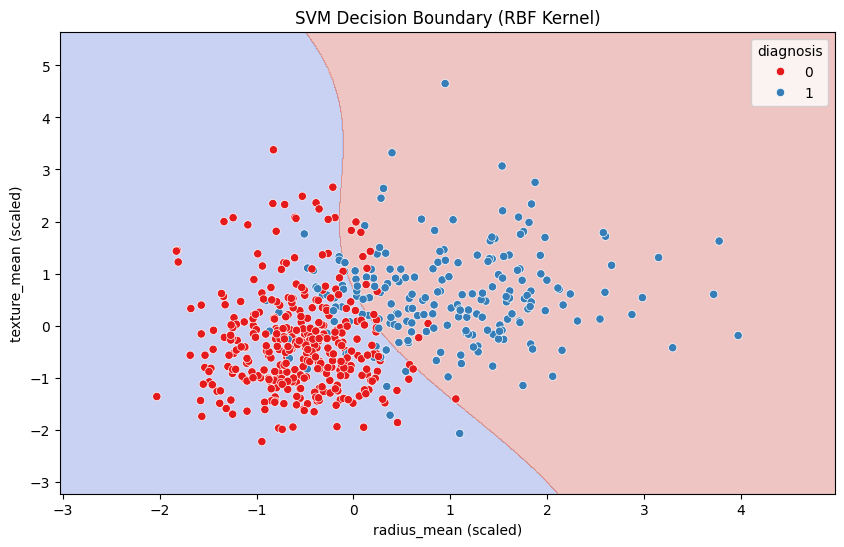

In [52]:
# Plot
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
sns.scatterplot(x=X_viz_scaled[:, 0], y=X_viz_scaled[:, 1], hue=y_viz, palette='Set1')
plt.title("SVM Decision Boundary (RBF Kernel)")
plt.xlabel("radius_mean (scaled)")
plt.ylabel("texture_mean (scaled)")
plt.show()